In [1]:
from datetime import datetime
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
import numpy as np
import mplfinance as mpf
import pandas as pd
from ta.volatility import BollingerBands

In [2]:
# No keys required for crypto data
client = CryptoHistoricalDataClient()
# Creating request object
request_params = CryptoBarsRequest(
  symbol_or_symbols=["BTC/USD"],
  timeframe=TimeFrame.Minute,
  start=datetime.fromisoformat('2025-03-02T09:00:00-05:00'),
  end=datetime.fromisoformat('2025-03-02T13:00:00-05:00')
)
# Retrieve daily bars for Bitcoin in a DataFrame and printing it
btc_bars = client.get_crypto_bars(request_params)
# Convert to dataframe
df = btc_bars.df
# Update indexes to use only timestamp, as we are doing single symbol analysis
df = df.droplevel('symbol')
df.index = df.index.tz_convert('US/Eastern')

In [3]:
from typing import Callable

def marker_signal_from_series(alpaca_df: pd.Series, transform_pair: Callable[[tuple[datetime, float]], float]) -> list[float]:
    source_iterable = alpaca_df.items()
    marker_signal: list[float] = list(map(transform_pair, source_iterable))
    return marker_signal

def datetime_marker_signal(series: pd.Series, datetimes: list[datetime]) -> list[float]:
    def transform_pair(dt_pair: tuple[datetime, float]):
        date, value =  dt_pair
        return value * 0.99 if date in datetimes else np.nan
    return marker_signal_from_series(series, transform_pair)

In [4]:
# Add markers at key points
datetimes_str: list[str] = ['2025-03-02T10:24:00-05:00', '2025-03-02T12:11:00-05:00']
datetimes: list[datetime] = [datetime.fromisoformat(x) for x in datetimes_str]
marker_signal = datetime_marker_signal(df.low, datetimes)
# Subplot for markers
markers = mpf.make_addplot(marker_signal, type='scatter', markersize=50, marker="*", color='blue', panel=0)

In [5]:
# Bollinger Bands
indicator_bb = BollingerBands(close=df.close, window=20, window_dev=2)
bollinger_bands = pd.DataFrame({
    'upper': indicator_bb.bollinger_hband(),
    'lower': indicator_bb.bollinger_lband()
})
def generate_high_marker_signal(series: pd.Series, comparison: pd.Series) -> list[float]:
    def transform_pair(dt_pair: tuple[datetime, float]):
        date, value =  dt_pair
        comparison_value = comparison.loc[date]
        return value * 1.01 if value > comparison_value else np.nan
    return marker_signal_from_series(series, transform_pair)
def generate_low_marker_signal(series: pd.Series, comparison: pd.Series) -> list[float]:
    def transform_pair(dt_pair: tuple[datetime, float]):
        date, value =  dt_pair
        comparison_value = comparison.loc[date]
        return value * 0.99 if value < comparison_value else np.nan
    return marker_signal_from_series(series, transform_pair)
bb_marker_high_signal = generate_high_marker_signal(df.close, indicator_bb.bollinger_hband())
bb_marker_low_signal = generate_low_marker_signal(df.close, indicator_bb.bollinger_lband())
# Subplot for BB
bb_subplot = mpf.make_addplot(bollinger_bands)
bb_high_marker_subplot = mpf.make_addplot(bb_marker_high_signal, type='scatter', markersize=10, marker="^", color='green', panel=0)
bb_low_marker_subplot = mpf.make_addplot(bb_marker_low_signal, type='scatter', markersize=10, marker="v", color='red', panel=0)

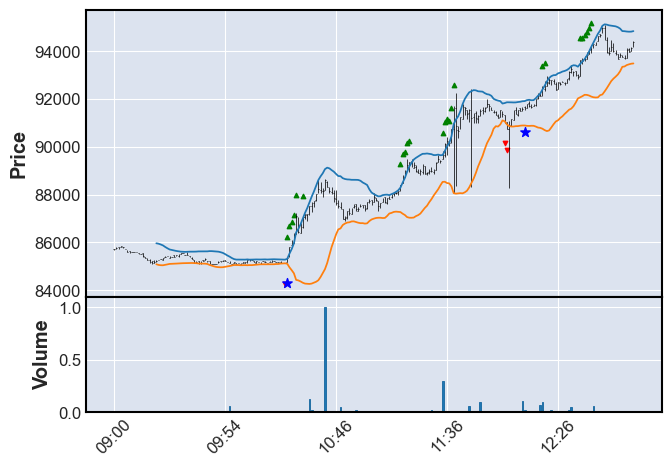

In [6]:
# Plot everything
subplts = [bb_subplot, bb_high_marker_subplot, bb_low_marker_subplot, markers]
plt = mpf.plot(df,volume=True,addplot=subplts)